In [148]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn

import sklearn.datasets
import sklearn.linear_model
from utils import plot_decision_boundary, sigmoid, load_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

In [149]:
X, Y = load_dataset()

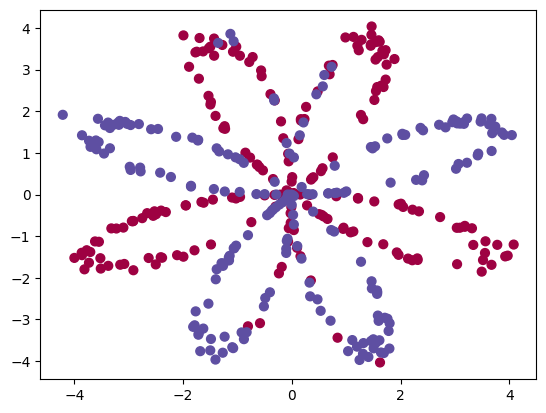

In [150]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [151]:
### START CODE HERE ### (≈ 3 lines of code)
shape_X = X.shape
shape_Y = Y.shape
m = shape_X[1]  # training set size
### END CODE HERE ###

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))
print(X[:,1])
print(Y[:,1])


The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!
[ 0.1587099 -1.4821709]
[0]


In [152]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
   ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[0] # size of input layer
    n_h1 = 80         # First hidden layer (increased from 8)
    n_h2 = 40        # Second hidden layer (kept)
    n_h3 = 40        # Third hidden layer (reduced from 3)
    n_y = Y.shape[0] # size of output layer
    ### END CODE HERE ###
    return (n_x, n_h1,n_h2,n_h3, n_y)
print()

In [153]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h1,n_h2,n_h3, n_y):
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = np.random.randn(n_h1,n_x)*0.01
    b1 = np.zeros((n_h1,1))

    W2 = np.random.randn(n_h2,n_h1)*0.01
    b2 = np.zeros((n_h2,1))

    W3 = np.random.randn(n_h3,n_h2)* 0.01
    b3 = np.zeros((n_h3,1))
    
    W4 = np.random.randn(n_y,n_h3)*0.01
    b4 = np.zeros((n_y,1))
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4
                  }
    
    return parameters

In [154]:
n_x,n_h1,n_h2,n_h3,n_y = layer_sizes(X,Y)
print(n_x,n_h1,n_h2,n_h3,n_y)

2 80 40 40 1


In [155]:
def ReLU(x):
    return np.maximum(0, x)

def forward_propagation(X, parameters,dropout_rate = 0.2):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    
 
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)  
    D1 = np.random.rand(*A1.shape) < (1 - dropout_rate)
    A1 *= D1
    A1 /= (1 - dropout_rate)


    Z2 = np.dot(W2, A1) + b2
    A2 = ReLU(Z2)  
    
    Z3 = np.dot(W3, A2) + b3
    A3 = ReLU(Z3)  
    
    # Output layer remains sigmoid for binary classification
    Z4 = np.dot(W4, A3) + b4
    A4 = sigmoid(Z4)  
    
    assert(A4.shape == (1, X.shape[1]))
    
    cache = {
        "Z1": Z1, "A1": A1,
        "Z2": Z2, "A2": A2,
        "Z3": Z3, "A3": A3,
        "Z4": Z4, "A4": A4,
        "D1":D1
    }
    
    return A4, cache

In [156]:
# GRADED FUNCTION: compute_cost

def compute_cost(A, Y, parameters, lambd=0.01):
    m = Y.shape[1]
    logprobs = np.multiply(np.log(A+1e-15), Y) + np.multiply(np.log(1-A+1e-15), (1-Y))
    cost = -np.sum(logprobs)/m
    
    if lambd > 0:
        L = len(parameters)//2
        reg_cost = sum(np.sum(np.square(parameters[f"W{l}"])) for l in range(1,L+1))
        cost += (lambd/(2*m)) * reg_cost
    return np.squeeze(cost)

In [157]:
def dReLU(x):
    return 1. * (x > 0)  

def backward_propagation(parameters, cache, X, Y,dropout_rate=0.2):
    m = X.shape[1]
     
    W1, W2, W3, W4 = parameters['W1'], parameters['W2'], parameters['W3'], parameters['W4']
    A1, D1, A2, A3, A4 = cache['A1'],cache['D1'] , cache['A2'], cache['A3'], cache['A4']
    Z1, Z2, Z3 = cache['Z1'], cache['Z2'], cache['Z3']
    
    # Backward propagation
    dZ4 = A4 - Y  
    dW4 = np.dot(dZ4, A3.T) / m
    db4 = np.sum(dZ4, axis=1, keepdims=True) / m
    
    # Layer 3 
    dA3 = np.dot(W4.T, dZ4)
    dZ3 = dA3 * dReLU(Z3)  
    dW3 = np.dot(dZ3, A2.T) / m
    db3 = np.sum(dZ3, axis=1, keepdims=True) / m
    
    # Layer 2 
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = dA2 * dReLU(Z2)  
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    
    # Layer 1 
    dA1 = np.dot(W2.T, dZ2)
    dA1 *= D1
    dA1 /= (1 - dropout_rate)
    dZ1 = dA1 * (1 - np.power(A1, 2))
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    
    grads = {
        "dW1": dW1, "db1": db1,
        "dW2": dW2, "db2": db2,
        "dW3": dW3, "db3": db3,
        "dW4": dW4, "db4": db4
    }
    
    return grads

In [158]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 0.):
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    ### END CODE HERE ###
    
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    dW3 = grads['dW3']
    db3 = grads['db3']
    dW4 = grads['dW4']
    db4 = grads['db4']
    ## END CODE HERE ###
    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1-learning_rate*dW1
    b1 = b1-learning_rate*db1
    W2 = W2-learning_rate*dW2
    b2 = b2-learning_rate*db2
    W3 = W3-learning_rate*dW3
    b3 = b3-learning_rate*db3
    W4 = W4-learning_rate*dW4
    b4 = b4-learning_rate*db4
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4
                  }
    
    return parameters

In [159]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y.T, test_size=0.2, random_state=42)
X_train, X_test, Y_train, Y_test = X_train.T, X_test.T, Y_train.T, Y_test.T

n_x, n_h1, n_h2, n_h3, n_y = layer_sizes(X_train, Y_train)
parameters = initialize_parameters(n_x, n_h1, n_h2, n_h3, n_y)
epochs = 30000
learning_rate = 0.09
train_losses = []
test_losses = []

best_cost = float('inf')
patience = 500

In [160]:
for epoch in range(epochs):
    A4_train, cache = forward_propagation(X_train, parameters)
    cost_train = compute_cost(A4_train, Y_train, parameters)
    grads = backward_propagation(parameters, cache, X_train, Y_train)
    parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
    
    A4_test, _ = forward_propagation(X_test, parameters)
    cost_test = compute_cost(A4_test, Y_test, parameters)
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{epochs}, Train Cost: {cost_train:.4f}, Test Cost: {cost_test:.4f}")
        train_losses.append(cost_train)
        test_losses.append(cost_test)

Epoch 0/30000, Train Cost: 0.6932, Test Cost: 0.6932
Epoch 1000/30000, Train Cost: 0.6928, Test Cost: 0.6960
Epoch 2000/30000, Train Cost: 0.6928, Test Cost: 0.6960
Epoch 3000/30000, Train Cost: 0.6928, Test Cost: 0.6960
Epoch 4000/30000, Train Cost: 0.6928, Test Cost: 0.6960
Epoch 5000/30000, Train Cost: 0.6928, Test Cost: 0.6960
Epoch 6000/30000, Train Cost: 0.6928, Test Cost: 0.6960
Epoch 7000/30000, Train Cost: 0.6928, Test Cost: 0.6960
Epoch 8000/30000, Train Cost: 0.6928, Test Cost: 0.6960
Epoch 9000/30000, Train Cost: 0.6928, Test Cost: 0.6960
Epoch 10000/30000, Train Cost: 0.6928, Test Cost: 0.6959
Epoch 11000/30000, Train Cost: 0.6928, Test Cost: 0.6958
Epoch 12000/30000, Train Cost: 0.6925, Test Cost: 0.6954
Epoch 13000/30000, Train Cost: 0.6876, Test Cost: 0.6888
Epoch 14000/30000, Train Cost: 0.6392, Test Cost: 0.5963
Epoch 15000/30000, Train Cost: 0.3766, Test Cost: 0.3164
Epoch 16000/30000, Train Cost: 0.3429, Test Cost: 0.3382
Epoch 17000/30000, Train Cost: 0.2968, Test 

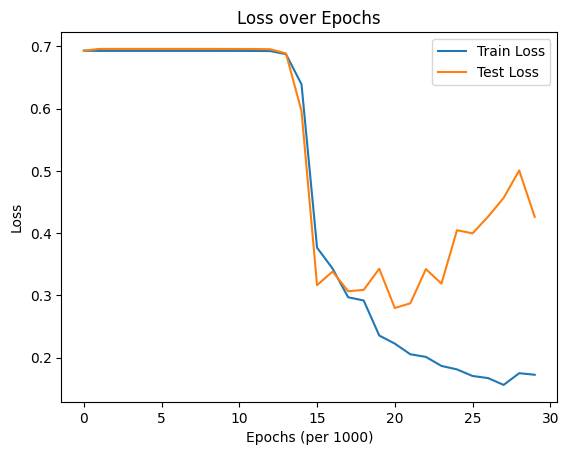

In [161]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epochs (per 1000)")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

In [162]:
def predict(parameters, X, threshold=0.5):
    A4, _ = forward_propagation(X, parameters)
    
    predictions = (A4 > threshold).astype(int)
    
    return predictions

In [163]:
predictions = predict(parameters, X)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.4675


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 1')

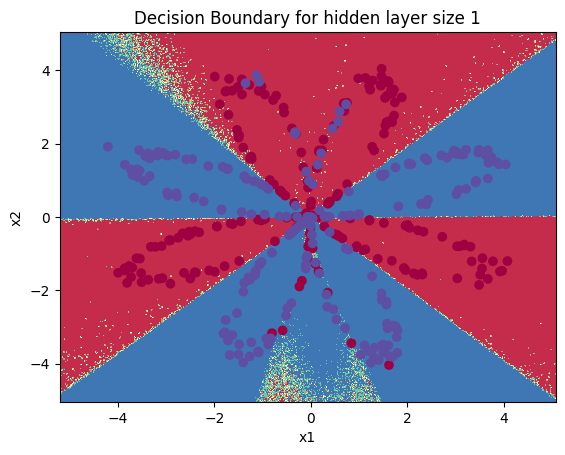

In [164]:
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(1))

In [165]:
train_preds = predict(parameters, X_train)
test_preds = predict(parameters, X_test)

# Calculate both test and train accuracy
train_accuracy = np.mean(train_preds == Y_train)
test_accuracy = np.mean(test_preds == Y_test)

print(f"Train Accuracy: {train_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Train Accuracy: 91.88%
Test Accuracy: 86.25%
